### Modelling carbon fluxes from wildfire

This example was developed using overmature_decline_and_litterfall.ipynb from the cbm3_scripting_examples repository as a template.

It shows how to initalize a stand and evaluate the carbon dynamics associated with stochastic fire disturbances in CBM-CFS3 using cbm3_python.  A uniform distrubution is used to model the stochastic effects of fire disturbances.

In [1]:
from itertools import chain
import os

from scipy.stats import uniform
import numpy as np
import scipy
from matplotlib import pyplot as plt
import pandas as pd
# %matplotlib inline

import cbm3_python.simulation.projectsimulator
from cbm3_python.cbm3data import cbm3_results
from cbm3_python.cbm3data import sit_helper
standard_import_tool_plugin_path=sit_helper.load_standard_import_tool_plugin()


from stochastic_disturbance import get_stochastic_disturbance_years
from yield_curves import site_class_yield_curve

C:\Users\b_gra\.conda\envs\cbm3\lib\site-packages\cbm3_python\cbm3data\sit_helper.py:27: UserWarning: This method is deprecated, please acquire and install Operational-Scale CBM-CFS3 version 1.2.7606.313 or newer.
  warn(


In [2]:
# Parameters

# These are some of the basic parameters we use for our simulation
# We will create one simulation for each Stand in our model.
n_stands = 100
# This is the simulation end year
end_age = 250
mean_disturbance_time = 100
# This is the resolution (in years) for our model
step_size = 1

# Seting up the project directory
toolbox_path = 'C:\Program Files (x86)\Operational-Scale CBM-CFS3'
# This is the directory for the project we will create
project_name = 'softwood_stochastic_disturbance_example'
# Let's store our project in the Projects folder of the CBM-CFS3 directory
project_main_path = toolbox_path + '\Projects' + '\\' + project_name
project_path = project_main_path + '\\' + project_name + ".mdb"
results_db_path = project_main_path + '\\' + project_name + '_results.mdb'
config_save_path =  project_main_path + '\\' + 'config.json'



# Variables used to define the yield curve
# This is representative of a softwood stand in BC
# Reference:  https://www.for.gov.bc.ca/hfd/pubs/docs/srs/Srs07.pdf
# Forest Inventory Zone: B
# Growth Type Group: A
# Site Class: M
cultivation_age = 59  # we don't use this in the example
final_age = end_age
age = np.arange(0, final_age, step_size)
b1 = 616.7332
b2 = -0.0607
b3 = 9.9966
b4 = 0

## Create the fire disturbance index for each stand

Here we want to sample from a probability distribution to determine the years
that a particular stand has a fire.  Here we adopt a simple approach using a
uniform probability distribution that can be updated using any standard
probability distribution (e.g. from `scipy.stats`).

(-5.0, 255.0)

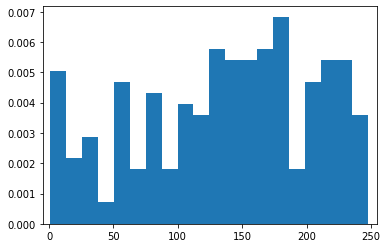

In [3]:
disturbances_by_simulation = get_stochastic_disturbance_years(
        simulations=n_stands,
        mean_disturbance_time=mean_disturbance_time,
        end_age=end_age,
        step_size=step_size)

def flatten_nested_list(nested_list):
    return list(chain(*nested_list))

all_disturbances = flatten_nested_list(disturbances_by_simulation)
_, _, _ = plt.hist(all_disturbances, density=True, bins=20)
plt.xlim(left=-5, right=end_age+5)

In [4]:
# Disturbance years for the first 5 stands.
disturbances_by_simulation[0:5]

[[142, 152], [9, 18, 175], [168], [62, 227, 246], [111, 136, 212]]

Depending on the `end_age` and `mean_disturbance_time`, the disturbance frequency is likely to have a peak at `mean_disturbance_time * 2`. This is because stands that have their first disturbance before `end_year` also have the potential for a second disturbance event.  Similarly, stands that have two disturbance events before `end_year` also have a probability of having a third disturbance before end_year and so on. 

# Setting up the basic configuration

Here we need to specify the directories that we need to run our model including the location of CBM-CFS3 and teh directories for 



In [5]:
sit_config = sit_helper.SITConfig(
    imported_project_path=project_path,
    initialize_mapping=True  # What is this for?
)

### Let's create an object to store the basic configuration requirements for a CBM-CFS3 stand model

In [6]:
sit_config.data_config(
    age_class_size=step_size,
    num_age_classes=int(end_age/step_size),
    # The 'Scenario' classifier is used to specify unique scenario names.
    # classifiers=["Leading Species", "Scenario"])
    classifiers=["Leading Species", "Stand ID"])

sit_config.set_single_spatial_unit(42)
sit_config.set_species_classifier("Leading Species")


## Defining a stand

## yield curve

The parameters for the yield curve are defined above.  In this example, a 1 year time steps is used. For a given stand age, the yield curve represents the yield (m3/ha) of merchantable wood.

<AxesSubplot:xlabel='age'>

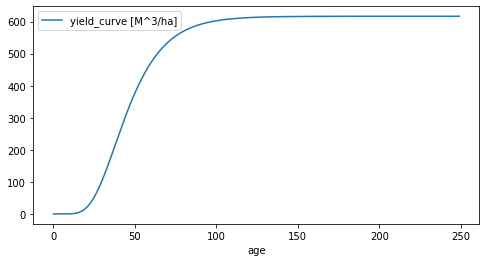

In [7]:
yield_curve = site_class_yield_curve(b1, b2, b3, b4, age)
assert len(yield_curve <= end_age/step_size), "CBM-CFS3 does not accept yield curves greater than end_age/step_size"
df = pd.DataFrame({"age": age, "yield_curve [M^3/ha]": yield_curve})
df.groupby("age").sum().plot(figsize=(8, 4))

In [8]:
"""
area=1 : int
    a 1 hectare stand.

age=0 : int
    This looks like the starting point where results are shown.
    It's not clear whether it is valid to start at any year since
    the model may need some spin-up time for the DOM pools to
    equilibriate.  In Tutorial 1, for example, the model setup seems
    to imply that most commont stand replace disturbance and most
    recent stand replacing disturbance need to be specified. Defining
    an arbitrary age may lead to some discontinuities.

classifier_set : 
    this is used to specify the stand.  In this case,
    we are setting the 'Spruce' stand with the 'fire disturbance'.
    Note that additional scenarios can be added in the same way by
    adding an new combination of 'Leading Species' and 'Scenario'.
    Using the same classifier_set combination will overwrite previous
    stands.

unfccc_land_class : 
    ?
"""

# iteratively adding scenarios
for i in range(len(disturbances_by_simulation)):
    sit_config.add_inventory(
        classifier_set=["Spruce", f"Stand {i+1}"],
        area=1, age=0, unfccc_land_class=0)
    sit_config.add_yield(
        classifier_set=["Spruce", f"Stand {i+1}"],
        leading_species_classifier_value="Spruce",
        values=list(yield_curve))

## Creating a disturbance event

In [9]:
"""
classifier_set : list
    A list of attributes used to describe a stand. In this example,
    classifier_set = ["?", "?"] means that the event is applied
    to all stands (stands with any value of "Leading Species" and
    "Scenario").

disturbance_type : str
    CBM-CFS3 disturbance type
time_step : int
    Year when disturbance occurs.
target : int
    Unclear what the target is.
target_type : str
sort : str
"""
# iteratively add disturbances for each scenario.
for i, disturbance_years in enumerate(disturbances_by_simulation):
    for year in disturbance_years:
        sit_config.add_event(classifier_set=["Spruce", f"Stand {i+1}"], disturbance_type="Wildfire", 
                      time_step=int(year), target=30, target_type="Area", sort="SORT_BY_SW_AGE")

## Running a CBM-CFS3 simulation using the project defined above

In [10]:
import time
start = time.time()

sit_config.import_project(standard_import_tool_plugin_path, config_save_path)

results_db_path = cbm3_python.simulation.projectsimulator.run(
    aidb_path=os.path.join(toolbox_path, "admin", "dbs", "ArchiveIndex_Beta_Install.mdb"), 
    project_path=os.path.abspath(project_path), 
    toolbox_installation_dir=toolbox_path,
    cbm_exe_path=os.path.join(toolbox_path, "admin", "executables"),
    results_database_path= results_db_path)

stop = time.time()
print(f'simulation time: {(stop-start)/60} minutes')

simulation time: 3.4077546993891397 minutes


## Viewing results from the simulation

In [11]:
def plot_samples(df, y=None, colors='Stand ID', n_samples=3):
    choices = np.random.choice(df[colors].unique(), n_samples)

    for choice in choices:
        plot_df = df[df[colors]==choice]
        plt.plot(plot_df['TimeStep'].values, plot_df[y].values)
    plt.legend(choices)
    
def plot_stand_average(df, y):
    df_average = df[['TimeStep', y]].groupby(['TimeStep'], axis=0).mean()
    df_average.plot()

### Pools

In [12]:
pool_results = cbm3_results.load_pool_indicators(results_db_path,classifier_set_grouping=True)

In [13]:
# Here are all the pools that we could inspect
pool_results.columns

Index(['TimeStep', 'UserDefdClassSetID', 'Aboveground Very Fast DOM',
       'Belowground Very Fast DOM', 'Aboveground Fast DOM',
       'Belowground Fast DOM', 'Medium DOM', 'Aboveground Slow DOM',
       'Belowground Slow DOM', 'Softwood Stem Snag', 'Softwood Branch Snag',
       'Hardwood Stem Snag', 'Hardwood Branch Snag', 'BlackCarbon', 'Peat',
       'Softwood Merchantable', 'Softwood Foliage', 'Softwood Other',
       'Softwood Coarse Roots', 'Softwood Fine Roots', 'Hardwood Merchantable',
       'Hardwood Foliage', 'Hardwood Other', 'Hardwood Coarse Roots',
       'Hardwood Fine Roots', 'Total Biomass', 'Aboveground Biomass',
       'Belowground Biomass', 'Total Ecosystem', 'Dead Organic Matter',
       'Aboveground DOM', 'Belowground DOM', 'Deadwood', 'Litter', 'Soil C',
       'Leading Species', 'Stand ID'],
      dtype='object')

### Let's take a look at the Total Biomass for three randomly selected stands.

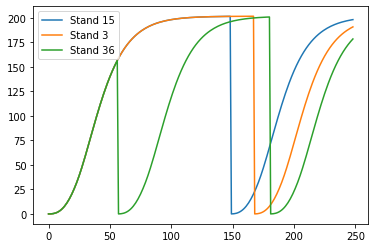

In [14]:
plot_samples(pool_results, y='Total Biomass')

### And now the Total Biomass averaged across all stands

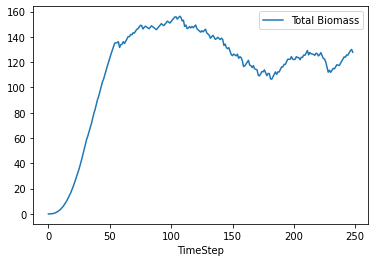

In [15]:
y='Total Biomass'
plot_stand_average(pool_results, y)

### Stocks

In [16]:
stock_change_results = cbm3_results.load_stock_changes(results_db_path, classifier_set_grouping=True)

In [17]:
# And here are the stock change results we could explore
stock_change_results.columns

Index(['TimeStep', 'UserDefdClassSetID', 'Delta Total Ecosystem',
       'Delta Total Biomass', 'Delta Total DOM',
       'Net Primary Productivity (NPP)', 'Net Ecosystem Productivity (NEP)',
       'Net Growth', 'Net Litterfall', 'Total Litterfall',
       'Decomposition Releases', 'NetCO2emissions_removals_CO2e',
       'SumofCOProduction_CO2e', 'SumofCH4Production_CO2e', 'N2O_CO2e',
       'ToFps_CO2e', 'Total Harvest (Biomass + Snags)',
       'Total Harvest (Biomass)', 'Total Harvest (Snags)',
       'Softwood Harvest (Biomass)', 'Hardwood Harvest (Biomass)', 'Deadwood',
       'Litter', 'Soil C', 'Aboveground Very Fast DOM Emissions',
       'Belowground Very Fast DOM Emissions', 'Aboveground Fast DOM Emissions',
       'Belowground Fast DOM Emissions', 'Medium DOM Emissions',
       'Aboveground Slow DOM Emissions', 'Belowground Slow DOM Emissions',
       'Softwood Stem Snag Emissions', 'Softwood Branch Snag Emissions',
       'Hardwood Stem Snag Emissions', 'Hardwood Branch Sn

### Net ecosystem product (the net carbon exchange) for three randomly selected stands

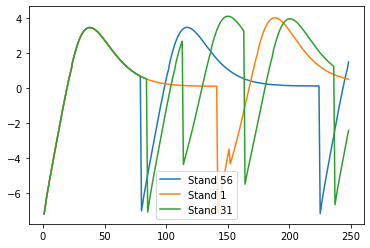

In [18]:
stock_change_to_plot = 'Net Ecosystem Productivity (NEP)'
plot_samples(stock_change_results, y=stock_change_to_plot, colors='Stand ID', n_samples=3)

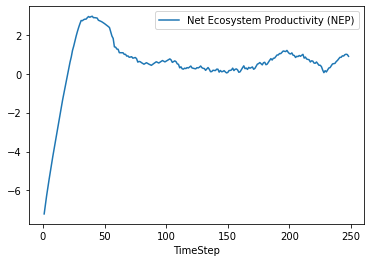

In [19]:
plot_stand_average(stock_change_results, stock_change_to_plot)